# Data preprocess

In [89]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
import cv2
import os

# parameters
NUM_EACH_SUBJECT = 170
NUM_SELFIES = 10
TRAIN_TEST_RATIO = 0.7
RANDOM_SEED = 22
np.random.seed(RANDOM_SEED)

def choose_random_idx(num, vmin, vmax, seed=RANDOM_SEED):
    np.random.seed(seed)
    idx = [i for i in range(vmin, vmax)]
    random_idx = np.random.permutation(idx)
    return sorted(random_idx[0 : num])

def get_train_test_list(input_list, ratio, seed=RANDOM_SEED):
    train_idx = choose_random_idx(num=round(len(input_list)*ratio), vmin=0, vmax=len(input_list), seed=RANDOM_SEED)

    train_list = []
    test_list = []
    for i in range(0,len(input_list)):
        if i in train_idx:
            train_list.append(input_list[i])
        else:
            test_list.append(input_list[i])
    return train_list, test_list

def get_pie_list(data_idx):
    # list of paths to PIE images
    pie_list = []
    pie_train_list = []
    pie_test_list = []

    for subj_idx in data_idx:
        subj_list = ['PIE/'+str(subj_idx)+'/'+str(i+1)+'.jpg' for i in range(0,NUM_EACH_SUBJECT)]
        subj_train_list, subj_test_list = get_train_test_list(subj_list, ratio=TRAIN_TEST_RATIO, seed=RANDOM_SEED)
        pie_train_list.extend(subj_train_list)
        pie_test_list.extend(subj_test_list)
        pie_list.extend(subj_list)
    return pie_list, pie_train_list, pie_test_list

def get_self_list():
    # list of paths to selfies
    self_list = ['selfimg/'+str(i+1)+'.jpg' for i in range(0,NUM_SELFIES)]
    self_train_list, self_test_list = get_train_test_list(self_list, ratio=TRAIN_TEST_RATIO, seed=RANDOM_SEED)
    return self_list, self_train_list, self_test_list

def get_img_vector(input_list):
    img_v = []
    labels = []
    for i in range(len(input_list)):
        path = input_list[i]
        pathsplit = path.split('/')
        img = cv2.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        img_v.append(img)
        if pathsplit[0] == 'PIE':
            labels.append(pathsplit[1])
        elif pathsplit[0] == 'selfimg':
            labels.append(pathsplit[0])
        else:
            print('Error: Wrong path list!')
        
    img_a = np.array(img_v)
    img_a = img_a.reshape(len(img_v), -1)
    
    labels_a = np.array(labels)
    
    return img_a, labels_a

#============================================================
data_idx = choose_random_idx(num=25, vmin=1, vmax=68, seed=RANDOM_SEED)

pie_list, pie_train_list, pie_test_list = get_pie_list(data_idx)
self_list, self_train_list, self_test_list = get_self_list()

# list of paths to all images of interest
list_img = pie_list + self_list
train_list = pie_train_list + self_train_list
test_list = pie_test_list + self_test_list


print('data_idx',data_idx)
print('Number of PIE images:', len(pie_list))
print('Number of PIE train images:', len(pie_train_list))
print('Number of PIE test images:', len(pie_test_list))
print('Number of self images:', len(self_list))
print('Number of self train images:', len(self_train_list))
print('Number of self test images:', len(self_test_list))
print('Number of whole train images:', len(train_list))
print('Number of whole test images:', len(test_list))

data_idx [1, 2, 4, 7, 13, 14, 16, 17, 22, 23, 26, 27, 29, 33, 36, 43, 47, 50, 52, 53, 57, 58, 63, 66, 67]
Number of PIE images: 4250
Number of PIE train images: 2975
Number of PIE test images: 1275
Number of self images: 10
Number of self train images: 7
Number of self test images: 3
Number of whole train images: 2982
Number of whole test images: 1278


# LDA

(2982, 2)


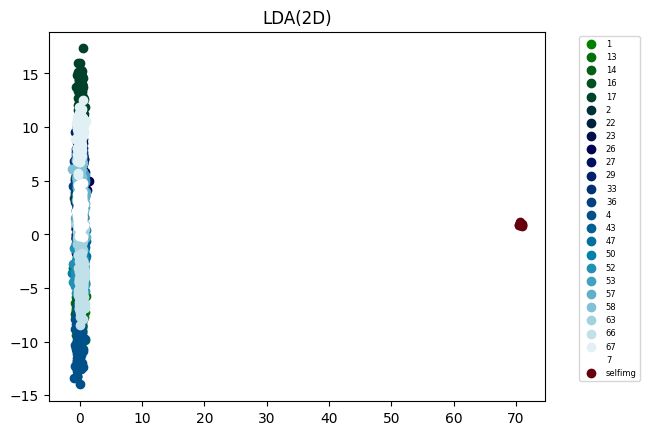

In [153]:
def get_scatter_matrix(data, label):
    data_train, labels_train = data, label
    averall = np.mean(data_train, axis=0)
    classes = np.unique(labels_train)
    class_num = len(classes)
    aver_vect = []
    Sb = np.zeros((data_train.shape[1], data_train.shape[1]), dtype=np.float32)
    Sw = np.zeros((data_train.shape[1], data_train.shape[1]), dtype=np.float32)
    for i in range(class_num):
        label = classes[i]
        num = np.sum(labels_train == label)
        num_start = np.sum(labels_train < label)
        num_end = num_start + num
        data_i = data_train[num_start:num_end, :]
        average = np.mean(data_i, axis=0)
       
        Sw = Sw + np.mat(data_i - average).T @ np.mat(data_i - average)
        Sb = Sb + num * np.mat(average - averall).T @ np.mat(average - averall)
        
    return Sw, Sb

def LDA(data, label, n_components):
    data_train = data
    labels_train = label
    Sw, Sb = get_scatter_matrix(data, label)
    matrix = np.linalg.inv(Sw) @ Sb
    #matrix = np.linalg.solve(Sw,Sb)
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    eigenvectors = np.real(eigenvectors)
    
    #normalize eigenvectors
    eigenvectors = eigenvectors / np.linalg.norm(eigenvectors, axis=0)

    #sort
    idx = np.argsort(-eigenvalues)
    eigenvectors = eigenvectors[:, idx]
    eigenvectors = eigenvectors[:, :n_components]
    X_lda = data_train @ eigenvectors
    return X_lda, eigenvectors

def draw_scatter(x, y, labels, cmap, title, xlabel, ylabel):
    classes = np.unique(labels)
    
    # Set legend color
    colorsmap = plt.get_cmap(cmap)
    colors = [colorsmap(i) for i in np.linspace(0, 1, len(classes)-1)]
    colors.append((0.403921568627451, 0.0, 0.05098039215686274, 1.0))
    
    # Plot the different class distributions
    class_distr = []
    for i in range(len(classes)):
        x1 = x[np.where(labels==classes[i])]
        x2 = y[np.where(labels==classes[i])]
        class_distr.append(plt.scatter(x1, x2, color=colors[i]))
    
    # Add a legend
    plt.legend(class_distr, classes, loc=1, fontsize=6, bbox_to_anchor=(1.2,1))      

    # Axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()   
    
#=======================================================================
X, Y = get_img_vector(train_list)
X_trans, eigen_v = LDA(X, Y, n_components=2)
print(X_trans.shape)
x1 = np.array(X_trans[:, 0])
x2 = np.array(X_trans[:, 1])

draw_scatter(x1, x2, labels=Y, cmap='ocean', title='LDA(2D)', xlabel=None, ylabel=None)

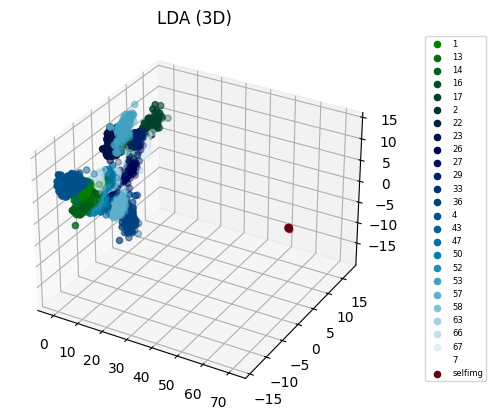

In [151]:
def draw_scatter_3d(x, y, z, labels, cmap, title, xlabel, ylabel, zlabel):
    classes = np.unique(Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Set legend color
    colorsmap = plt.get_cmap(cmap)
    colors = [colorsmap(i) for i in np.linspace(0, 1, len(classes)-1)]
    colors.append((0.403921568627451, 0.0, 0.05098039215686274, 1.0))

    # Plot the different class distributions
    class_distr = []
    for i in range(len(classes)):
        x1 = x[np.where(labels==classes[i])]
        x2 = y[np.where(labels==classes[i])]
        x3 = z[np.where(labels==classes[i])]
        class_distr.append(ax.scatter(xs=x1, ys=x2, zs=x3, color=colors[i]))

    # Add a legend
    ax.legend(class_distr, classes, loc=1, fontsize=6, bbox_to_anchor=(1.3,1))

    # Axis labels
    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    plt.show()   
#=================================================================
pie_train_imgs, pie_train_labels = get_img_vector(pie_train_list)
self_train_imgs, self_train_labels = get_img_vector(self_train_list)
X = np.r_[pie_train_imgs[:, :] , self_train_imgs[:, :]]
Y = np.r_[pie_train_labels[:] , self_train_labels[:]]
X_trans,eigen_v = LDA(X, Y, n_components=3)
x1 = X_trans[:, 0]
x2 = X_trans[:, 1]
x3 = X_trans[:, 2]

draw_scatter_3d(x1, x2, x3, labels=Y, cmap='ocean', 
                title = 'LDA (3D)',
                xlabel = None,
                ylabel = None,
                zlabel = None)


In [136]:
def get_class_accuracy(train_data_list, test_data_list, dimensionality, k=1):
    train_imgs, train_labels = get_img_vector(train_data_list)
    test_imgs, test_labels = get_img_vector(test_data_list)
    for r in dimensionality:
        data_train_new, eigen_v = LDA(train_imgs, train_labels, n_components=r)
        data_test_new = test_imgs @ eigen_v

        data_test_new = np.array(data_test_new)
        data_train_new = np.array(data_train_new)

        count = 0
        for i in range(test_imgs.shape[0]):
            test = data_test_new[i]
            tmp = (data_train_new - test) ** 2
            dist = np.sum(tmp, axis=1)
            min_idx = np.argmin(dist)  
            if train_labels[min_idx] == test_labels[i]:
                count += 1
            accuracy = float(count/ test_imgs.shape[0]) * 100

        print('Dimensionality is:', r)
        print('The accuracy is: {}%'.format(np.round(accuracy, 2)))
#=============================================================================
dimensionality = [2, 3, 9]
print('PIE dataset')
get_class_accuracy(pie_train_list, pie_test_list, dimensionality, k=1)
print('Self dataset')
get_class_accuracy(self_train_list, self_test_list, dimensionality, k=1)

PIE dataset
Dimensionality is: 2
The accuracy is: 44.71%
Dimensionality is: 3
The accuracy is: 60.78%
Dimensionality is: 9
The accuracy is: 92.39%
Self dataset
Dimensionality is: 2
The accuracy is: 100.0%
Dimensionality is: 3
The accuracy is: 100.0%
Dimensionality is: 9
The accuracy is: 100.0%
